# We know *where aircraft flew.*  What were their acoustic properties on the ground?

Current issues: https://github.com/dbetchkal/NMSIM-Python/issues

In [1]:
# this module contains a list of libraries, functions, and global constants used in this workbook
# import everything using wildcard (*)
from NMSIM_DENA_Flight_Tracks import *

#### <font color="gray">Reference *[Optional]:*</font> using `iyore` what sites were deployed concurrent to GPS data collection?
 <font color="gray">Use this cell if you need a refresher on the available sites.</font>

In [ ]:
# find Denali sites from 2019, 2020
np.unique([e.site for e in archive.dataDir(unit="DENA", year=["2019", "2020"])])

## Step 1: Select GPS points, convert to NMSIM trajectories *(.trj)*
**Also create an NMSIM *.sit* file!** <br><br>
Given
>NPS monitoring site <br>
>year <br>
>how far away are you interested in vehicle motion (kilometers) <br>

#### <font color=salmon size=4>You must edit lines 3 - 5.</font>

DENAUWBT2017: 648036, 7034587 - UTM zone 5
	microphone height 4.40 feet.


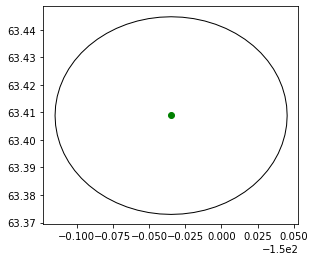


	Searching from 2017-07-31 and ends 2017-08-26 

SELECT flights.id, flights.departure_datetime, flights.registration, flights.operator_code, flights.flight_id, flights.submission_method, flights.duration_hrs, flights.landing_datetime, flights.agol_global_id, flights.ticket, flights.track_editor, flights.submitter_notes, flights.nps_mission_code, flights.nps_work_group, flights.submission_time, flights.nps_work_group_other, flight_points.longitude, flight_points.latitude, flight_points.knots, flight_points.heading, flight_points.altitude_ft, flight_points.ak_datetime, flight_points.geom, flight_points.utc_datetime FROM flight_points
          INNER JOIN flights ON flights.id = flight_points.flight_id 
          
          WHERE 
             ak_datetime::date BETWEEN '2017-07-31' AND '2017-08-26' AND 
             flight_points.ak_datetime::time >= '00:00' AND flight_points.ak_datetime::time <= '23:59'
             
              AND ST_Intersects(geom, ST_GeomFromText('POLYGON ((-149.

array(['N619CH', 'N72309', 'N74PS', 'N72395'], dtype=object)

In [2]:
# =============  EDIT  =====================================================
#   DEFINE THE PROJECT DIRECTORY and YEAR
project_dir = r"D:\Sound\NMSIm_Projects\DENAUWBT"
year = 2017
how_far_away = 4 # km
# ==========================================================================

# extract the site name from the project directory path
site = project_dir[-4:]

# create a table of all the flights
tracks = tracks_within(archive, site, year, 
                       search_within_km = how_far_away, 
                       aircraft_specs=False,
                       NMSIM_proj_dir = project_dir,
                       decouple=False)

# which N-Numbers were observed on this record?
tracks.registration.unique()

## Step 2: Run the models in NMSIM
#### <font color=salmon>Repeat for each N-Number of interest, *then* proceed to the next cell.</font>

In [9]:
# ============= EDIT ===================================================

# FAA registry for aircraft of interest
Focal_NNumber = "N72395"

# ======================================================================

# determine the location of the NMSIM program directiory
path_to_this_notebook = !echo %cd%
NMSIMpath =  path_to_this_notebook[0] + os.sep + "NMSIM"

# lookup for appropriate NMSIM source file
source_map = {"N8888": NMSIMpath + os.sep + "Sources\MiscellaneousSources\omni.src",
              "N709M": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C182.src",
             "N570AE": NMSIMpath + os.sep + "Sources\AirTourHelicopterSources\AS350.src",
              "N74PS": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N619CH": NMSIMpath + os.sep +  "Sources\AirTourFixedWingSources\C207.src",
             "N72309": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N72395": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N473YC": NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C207.src",
             "N21HY":  NMSIMpath + os.sep + "Sources\AirTourFixedWingSources\C182.src"}


# run the NMSIM model
NMSIM_create_tis(project_dir, source_map[Focal_NNumber], Nnumber=Focal_NNumber)

## Step 3: Pair NMSIM results to NPS acoustic measurements

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170607_232316.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170607_232316.tis
now working on run: N619CH_20170607_232316
Alaska start time 2017-06-07 15:23:16


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170717_192110.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170717_192110.tis
now working on run: N619CH_20170717_192110
Alaska start time 2017-07-17 11:21:10


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170722_194739.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170722_194739.tis
now working on run: N619CH_20170722_194739
Alaska start time 2017-07-22 11:47:39


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170730_191638.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170730_191638.tis
now working on run: N619CH_20170730_191638
Alaska start time 2017-07-30 11:16:38


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170730_203323.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170730_203323.tis
now working on run: N619CH_20170730_203323
Alaska start time 2017-07-30 12:33:23


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170805_233742.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170805_233742.tis
now working on run: N619CH_20170805_233742
Alaska start time 2017-08-05 15:37:42


  0%|          | 0/1 [00:00<?, ?entries/s]

NVSPL shape: (692, 31)
NMSIM shape: (392, 31)


C:\Users\DBetchkal\PythonScripts\GITHUB\NMSIM-Python\NMSIM_DENA_Flight_Tracks.py:883: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


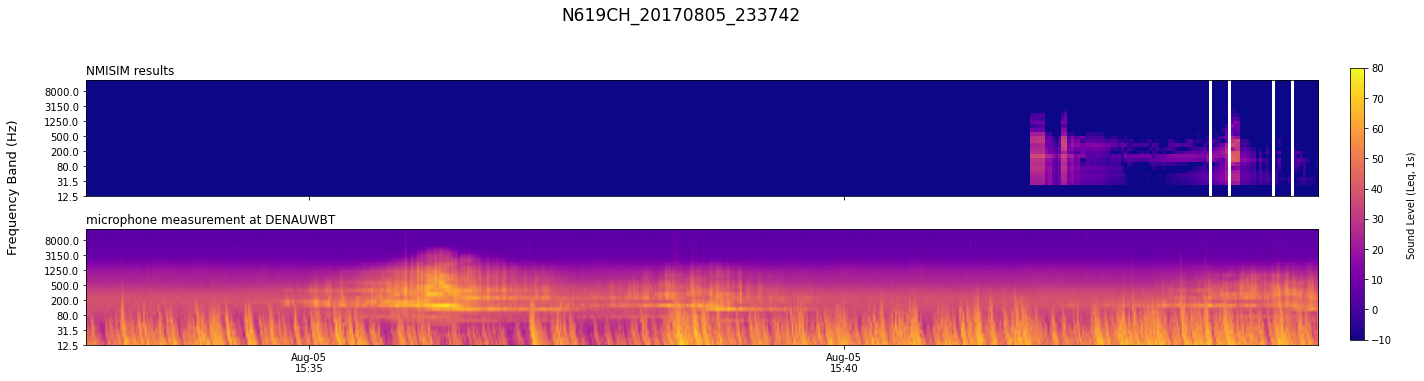

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170805_233801.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170805_233801.tis
now working on run: N619CH_20170805_233801
Alaska start time 2017-08-05 15:38:01


  0%|          | 0/1 [00:00<?, ?entries/s]

NVSPL shape: (656, 31)
NMSIM shape: (356, 31)


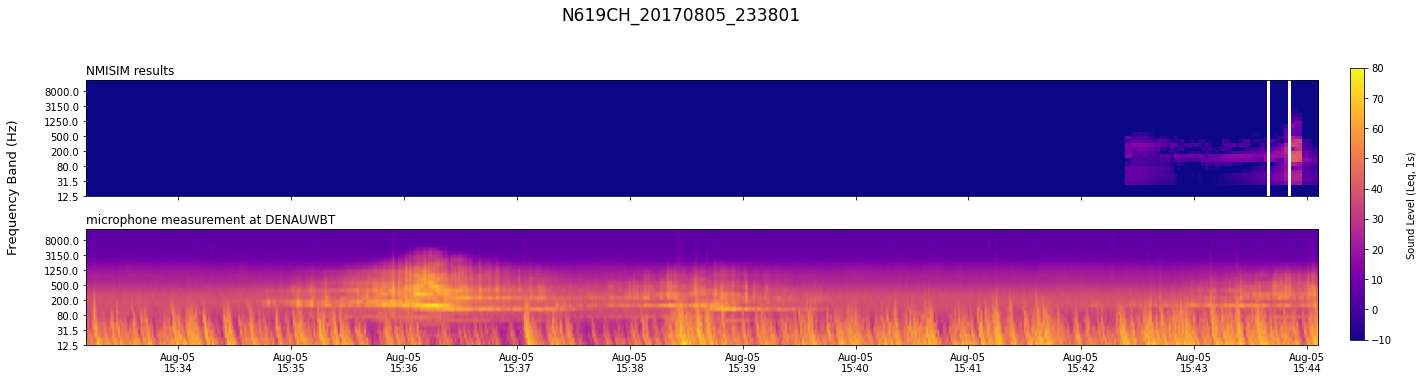

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170806_191128.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170806_191128.tis
now working on run: N619CH_20170806_191128
Alaska start time 2017-08-06 11:11:28


  0%|          | 0/1 [00:00<?, ?entries/s]

NVSPL shape: (742, 31)
NMSIM shape: (442, 31)


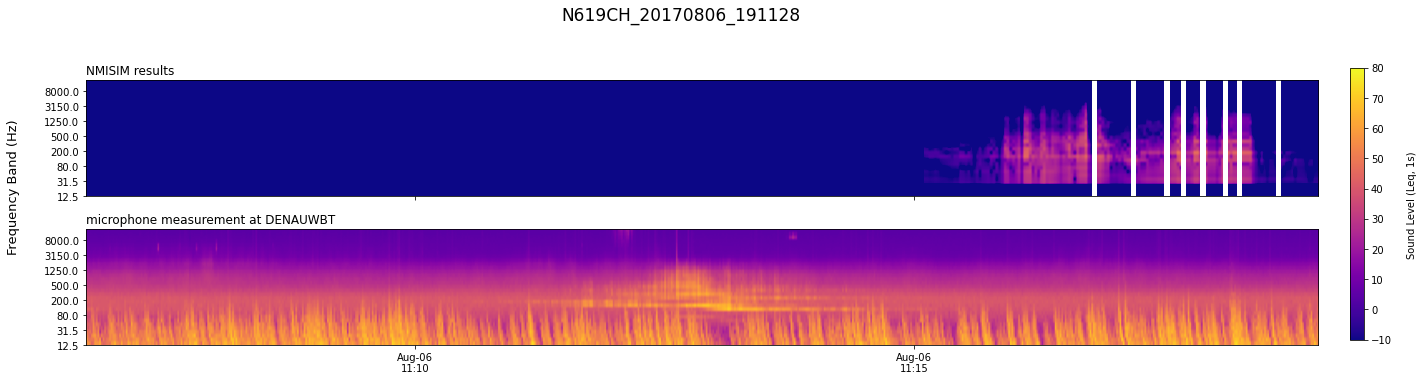

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170806_191151.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170806_191151.tis
now working on run: N619CH_20170806_191151
Alaska start time 2017-08-06 11:11:51


  0%|          | 0/1 [00:00<?, ?entries/s]

NVSPL shape: (697, 31)
NMSIM shape: (397, 31)


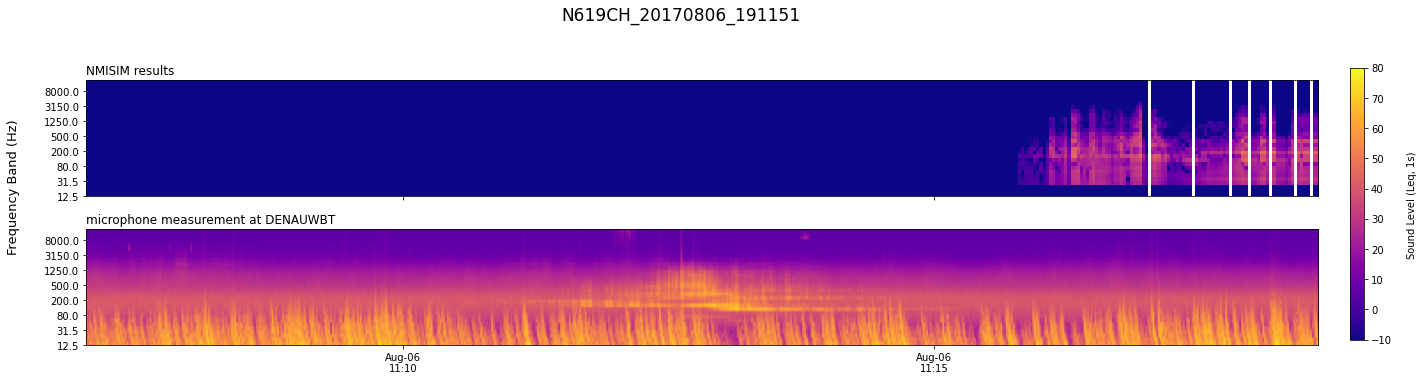

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170806_202709.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170806_202709.tis
now working on run: N619CH_20170806_202709
Alaska start time 2017-08-06 12:27:09


  0%|          | 0/1 [00:00<?, ?entries/s]

NVSPL shape: (692, 31)
NMSIM shape: (392, 31)


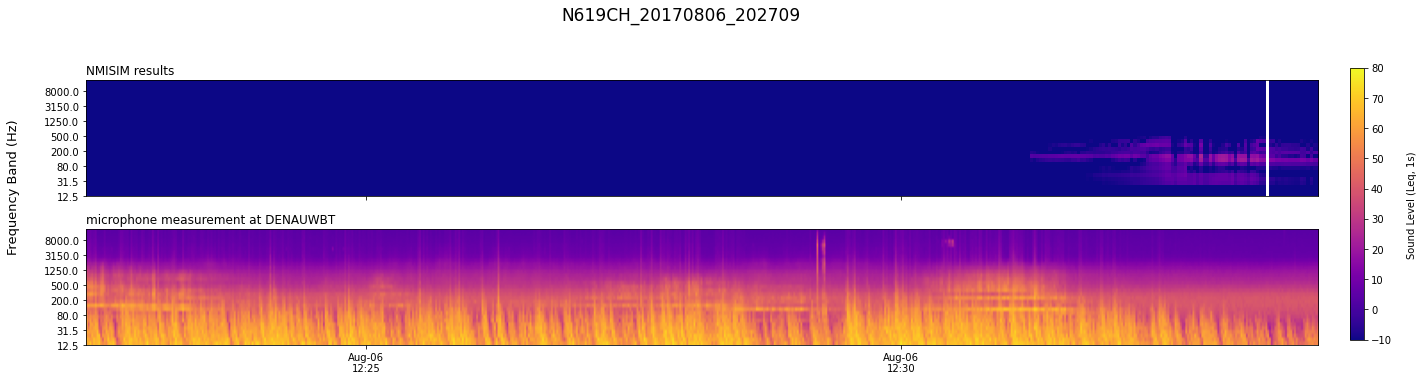

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170826_191229.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170826_191229.tis
now working on run: N619CH_20170826_191229
Alaska start time 2017-08-26 11:12:29


  0%|          | 0/1 [00:00<?, ?entries/s]

NVSPL shape: (705, 31)
NMSIM shape: (405, 31)


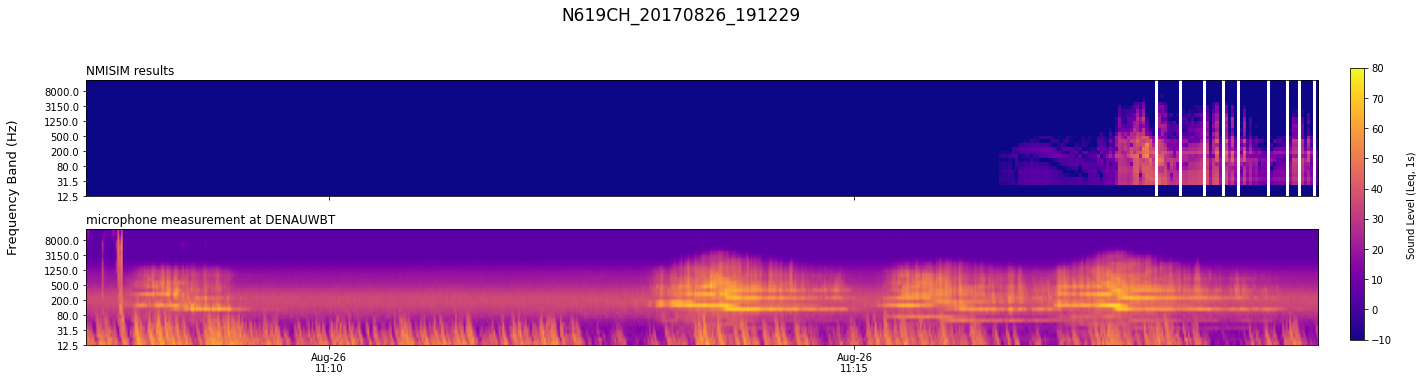

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20170826_191317.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20170826_191317.tis
now working on run: N619CH_20170826_191317
Alaska start time 2017-08-26 11:13:17


  0%|          | 0/1 [00:00<?, ?entries/s]

NVSPL shape: (626, 31)
NMSIM shape: (326, 31)


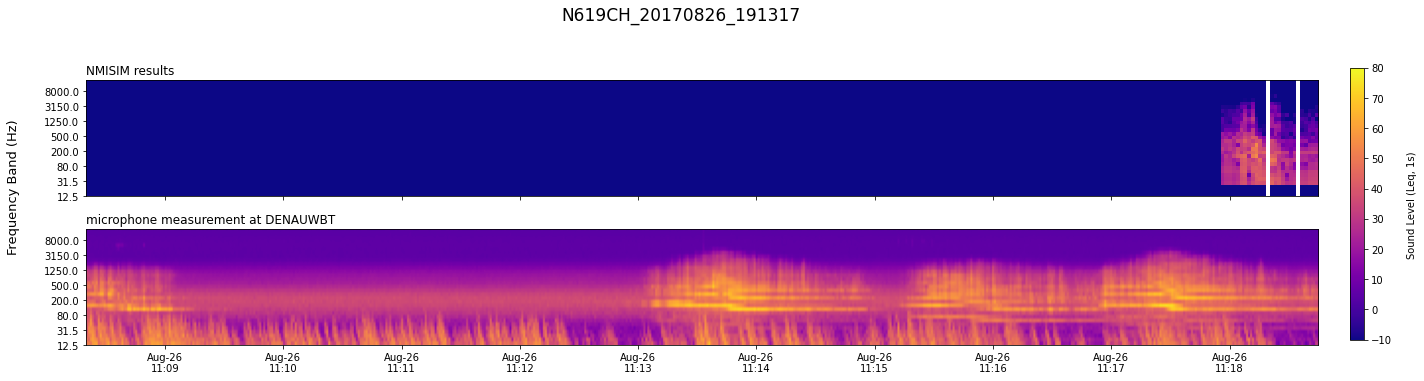

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20180722_201512.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20180722_201512.tis
now working on run: N619CH_20180722_201512
Alaska start time 2018-07-22 12:15:12


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20180729_232030.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20180729_232030.tis
now working on run: N619CH_20180729_232030
Alaska start time 2018-07-29 15:20:30


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20180910_010214.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20180910_010214.tis
now working on run: N619CH_20180910_010214
Alaska start time 2018-09-09 17:02:14


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20180911_190951.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20180911_190951.tis
now working on run: N619CH_20180911_190951
Alaska start time 2018-09-11 11:09:51


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20190622_192646.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20190622_192646.tis
now working on run: N619CH_20190622_192646
Alaska start time 2019-06-22 11:26:46


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N619CH_20190811_204204.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N619CH_20190811_204204.tis
now working on run: N619CH_20190811_204204
Alaska start time 2019-08-11 12:42:04


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N72309_20190608_203024.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N72309_20190608_203024.tis
now working on run: N72309_20190608_203024
Alaska start time 2019-06-08 12:30:24


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N72309_20190609_191101.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N72309_20190609_191101.tis
now working on run: N72309_20190609_191101
Alaska start time 2019-06-09 11:11:01


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N72309_20190714_001746.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N72309_20190714_001746.tis
now working on run: N72309_20190714_001746
Alaska start time 2019-07-13 16:17:46


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N74PS_20170826_191622.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N74PS_20170826_191622.tis
now working on run: N74PS_20170826_191622
Alaska start time 2017-08-26 11:16:22


  0%|          | 0/1 [00:00<?, ?entries/s]

NVSPL shape: (721, 31)
NMSIM shape: (421, 31)


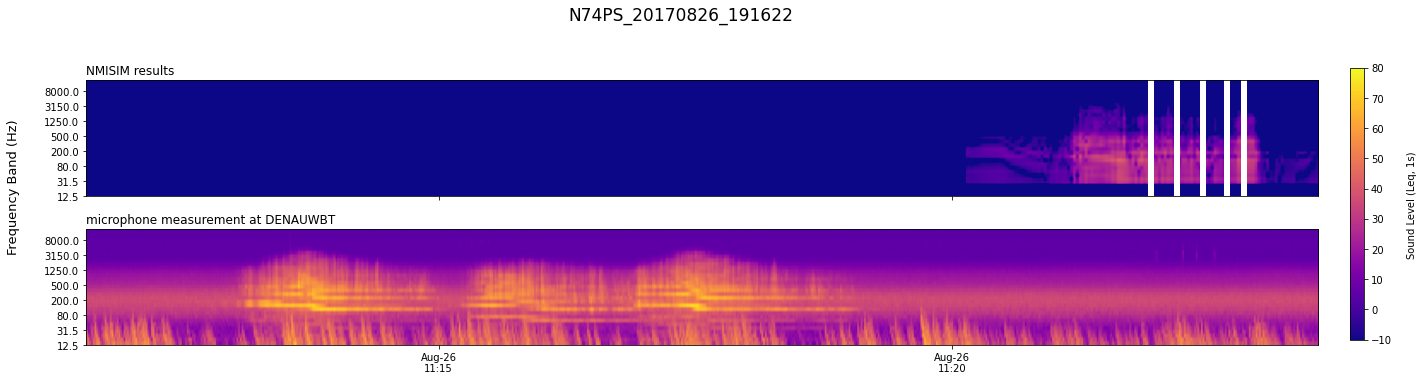

D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N74PS_20190614_232606.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N74PS_20190614_232606.tis
now working on run: N74PS_20190614_232606
Alaska start time 2019-06-14 15:26:06


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!
D:\Sound\NMSIm_Projects\DENAUWBT\Input_Data\03_TRAJECTORY\N74PS_20190819_181005.trj 
 D:\Sound\NMSIm_Projects\DENAUWBT\Output_Data\TIG_TIS\DENAUWBT_N74PS_20190819_181005.tis
now working on run: N74PS_20190819_181005
Alaska start time 2019-08-19 10:10:05


|          | 0/0 [00:00<?, ?entries/s]

Trajectory has no matching acoustic data!


In [10]:
# NMSIM isn't always successful - we want to iterate only through files that WERE created
trj_and_tis = pair_trj_to_tis_results(project_dir)

# (whether or not to show diagnostic plots; default: False)
diagnostic = False

for trj, tis in trj_and_tis:
    
    print(trj, "\n", tis)
    
    runName = os.path.basename(trj)[:-4]
    
    # read just the header of the trajectory
    with open(trj) as lines:
        head = [next(lines) for x in range(12)]

    # here's the string containing the starting time (to the second!)
    dateString = head[-1][-24:-5]

    # convert to a datetime object
    startdate = dt.datetime.strptime(dateString, "%Y-%m-%d %H:%M:%S")

    print("now working on run:", runName)
    
    try:
        # this is the theoretical 1/3rd octave band trace
        theory = tis_resampler(tis, startdate)
        
    except:
        print("tis", tis)
        print("produced a ValueError related to nan values in the .tis file")
    
    try:
    
        # compare and save results
        event_SPL = NVSPL_to_match_tis(archive, project_dir, 
                                       startdate, theory, trj, 
                                       unit="DENA", site=site, year=int(startdate.year),
                                       utc_offset=-8, pad_length=5)
        
    except AttributeError: 
        
        # sometimes there are gaps in the record that would 'appear' to be computable
        # ... but aren't... 
        print("Trajectory has no matching acoustic data!")
    
    # show diagnostic plots
    if(diagnostic == True):
        
        plt.figure(figsize=(14, 3))
        plt.plot(theory.index, theory["A"], zorder=5, ls="", marker="o", ms=2)
        plt.legend(loc="best")
        plt.show()